In [ ]:
#Ejercicio 1

In [85]:
import os
os.environ['USE_PYGEOS'] = '0'


import geopandas as gpd

from  fiona import listlayers
#link con los mapas 
canadaMapsLink="https://github.com/AnaLuciaChamorro/geoCanadadf/raw/main/maps/countryMaps.gpkg"

#layers in maps
listlayers(canadaMapsLink)

['provinces', 'cities', 'rivers', 'lakes', 'road']

In [86]:
canadaAirportsLink="https://github.com/AnaLuciaChamorro/gdfCanada/raw/main/maps/airports_3347.gpkg"
listlayers(canadaAirportsLink)

['airports']

In [87]:
#leemos la data de los layers
airports=gpd.read_file(canadaAirportsLink,layer='airports')
rivers=gpd.read_file(canadaMapsLink,layer='rivers')
provinces=gpd.read_file(canadaMapsLink,layer='provinces')

In [88]:
import pandas as pd 
infoseaports=pd.read_csv(os.path.join("data","UpdatedPub150.csv"))

#columns available (so many)
infoseaports.columns.to_list()

['World Port Index Number',
 'Region Name',
 'Main Port Name',
 'Alternate Port Name',
 'UN/LOCODE',
 'Country Code',
 'World Water Body',
 'IHO S-130 Sea Area',
 'Sailing Direction or Publication',
 'Publication Link',
 'Standard Nautical Chart',
 'IHO S-57 Electronic Navigational Chart',
 'IHO S-101 Electronic Navigational Chart',
 'Digital Nautical Chart',
 'Tidal Range (m)',
 'Entrance Width (m)',
 'Channel Depth (m)',
 'Anchorage Depth (m)',
 'Cargo Pier Depth (m)',
 'Oil Terminal Depth (m)',
 'Liquified Natural Gas Terminal Depth (m)',
 'Maximum Vessel Length (m)',
 'Maximum Vessel Beam (m)',
 'Maximum Vessel Draft (m)',
 'Offshore Maximum Vessel Length (m)',
 'Offshore Maximum Vessel Beam (m)',
 'Offshore Maximum Vessel Draft (m)',
 'Harbor Size',
 'Harbor Type',
 'Harbor Use',
 'Shelter Afforded',
 'Entrance Restriction - Tide',
 'Entrance Restriction - Heavy Swell',
 'Entrance Restriction - Ice',
 'Entrance Restriction - Other',
 'Overhead Limits',
 'Underkeel Clearance Manage

In [89]:
#renombramos el nombre de los puertos
infoseaports.rename(columns={'Main Port Name':'portName'},inplace=True)
#seleccionamos solo las columnas con las que nos quedaremos
infoseaports=infoseaports.loc[:,['portName', 'Country Code','Latitude', 'Longitude']]
infoseaports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3774 entries, 0 to 3773
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   portName      3774 non-null   object 
 1   Country Code  3774 non-null   object 
 2   Latitude      3774 non-null   float64
 3   Longitude     3774 non-null   float64
dtypes: float64(2), object(2)
memory usage: 118.1+ KB


In [90]:
#verificamos que las capas tengan el mismo crs
provinces.crs.to_epsg()==airports.crs.to_epsg()==rivers.crs.to_epsg()

False

In [91]:
#identificamos que crs es el discordante
provinces.crs.to_epsg(),airports.crs.to_epsg(),rivers.crs.to_epsg()

(4326, 3347, 4326)

In [92]:
#cambiamos el crs de las provincias y ríos
rivers=rivers.to_crs(3347)
provinces=provinces.to_crs(3347)

In [93]:
provinces.crs.to_epsg()==airports.crs.to_epsg()==rivers.crs.to_epsg()

True

In [94]:
#creamos un geodataframe
seaports=gpd.GeoDataFrame(data=infoseaports.copy(),
                 geometry=gpd.points_from_xy(infoseaports.Longitude,
                                             infoseaports.Latitude), 
                 crs=4326)#no está proyectado

seaports_canada=seaports[seaports['Country Code']=='Canada'].copy()

seaports_canada.reset_index(drop=True, inplace=True)
#proyectamos con el crs de Canada
seaports_canada_3347=seaports_canada.to_crs(3347) 

<Axes: >

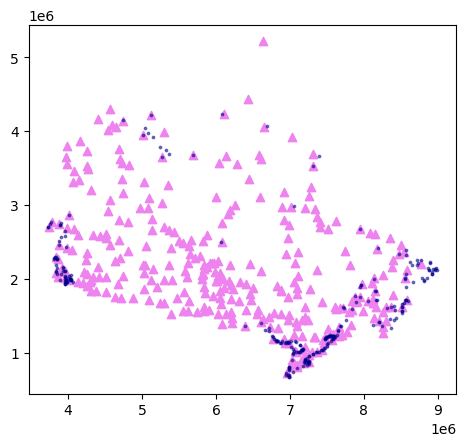

In [95]:
# seleccionamos el subconjunto de los aeropuertos medianos
mediumAirports=airports[airports.kind=='medium_airport'] 
mediumAirports.reset_index(drop=True, inplace=True)

#ploteamos
base=mediumAirports.plot(color='violet',marker="^")
seaports_canada_3347.plot(color='darkblue',ax=base,alpha=0.5,markersize=3)

In [96]:
#puertos
seaports_canada_3347.head()

,portName,Country Code,Latitude,Longitude,geometry
0,Port Severn,Canada,44.800000,-79.716667,POINT (7173072.050 1051169.583)
1,Little Bras D Or,Canada,46.250000,-60.300000,POINT (8562542.390 1720093.723)
2,Hilton,Canada,46.250000,-83.883333,POINT (6821112.908 1160542.204)
3,Kagawong,Canada,45.916667,-82.250000,POINT (6952950.534 1141032.855)
4,Douglastown,Canada,48.766667,-64.383333,POINT (8159882.288 1833159.695)


In [97]:
#aeropuertos medianos
mediumAirports.head()

,name,kind,latitude_deg,longitude_deg,elevation_ft,region_name,municipality,geometry
0,Billy Bishop Toronto City Centre Airport,medium_airport,43.627499,-79.396202,252.0,Ontario,Toronto,POINT (7224333.646 925621.026)
1,London Airport,medium_airport,43.035599,-81.153900,912.0,Ontario,London,POINT (7092745.018 832780.612)
2,John C. Munro Hamilton International Airport,medium_airport,43.173599,-79.934998,780.0,Ontario,Hamilton,POINT (7190253.037 866321.421)
3,Regina International Airport,medium_airport,50.431900,-104.666000,1894.0,Saskatchewan,Regina,POINT (5301503.877 1678527.853)
4,Kelowna International Airport,medium_airport,49.956100,-119.377998,1421.0,British Columbia,Kelowna,POINT (4293620.839 1953961.073)


In [154]:
# distancia entre 'Billy Bishop Toronto City Centre Airport' and 'Port Severn' en km
mediumAirports.iloc[0].geometry.distance(seaports_canada_3347.iloc[0].geometry)/1000
#dividimos entre 1000 porque inicialmente está en m

135.6104388383299

In [155]:
#try 1
seaports_canada_3347.geometry.apply\
(lambda g: mediumAirports.geometry.distance(g)/1000)

,0,1,2,3,4,5,6,7,8,9,...,318,319,320,321,322,323,324,325,326,327
0,135.610439,232.693306,185.644901,1973.916368,3017.659979,2141.372100,261.199449,161.389172,463.675998,843.923902,...,672.827721,2015.704293,3784.172680,3363.392908,3117.863858,1905.057341,3449.642045,1052.304577,1695.562604,1912.434716
1,1556.274240,1716.866003,1616.200857,3261.303406,4275.322811,3361.682116,1316.679831,1639.264816,1078.431202,2202.901525,...,1942.228546,2826.132876,4637.212995,4173.577661,3876.283103,1730.707444,4706.769212,2364.522918,2775.432149,2905.497660
2,466.663608,425.689634,472.049048,1605.465895,2649.099783,1775.230503,624.405659,423.183645,774.789325,477.295214,...,350.191394,1716.860673,3447.136013,3036.328153,2802.307151,1862.786618,3081.113145,687.472114,1352.659085,1579.602875
3,346.483837,338.470004,363.013567,1736.714407,2780.806845,1903.657619,491.301072,316.504561,647.197217,606.180289,...,447.592670,1808.547188,3558.498158,3142.616415,2902.944422,1849.262280,3213.131021,814.672009,1466.168947,1687.923523
4,1303.410026,1462.716741,1369.290741,2862.557972,3868.148208,2955.079293,1073.880754,1382.113192,812.717891,1832.464993,...,1567.255831,2408.296538,4222.073149,3759.187349,3463.343130,1382.287815,4298.337480,1981.635666,2362.893231,2488.739756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,3588.511548,3499.102925,3577.397992,1524.956305,484.154694,1377.426067,3750.307427,3528.807083,3844.819908,2656.793790,...,2870.866972,2069.754129,1394.799545,1484.039556,1655.063581,3580.873591,120.207673,2453.449910,1957.771472,1865.284028
257,3663.313909,3578.774374,3654.619321,1598.656539,579.921832,1434.753308,3818.709279,3605.752194,3904.458356,2726.295561,...,2932.406230,2066.250078,1262.169996,1381.524595,1572.042886,3573.597409,270.254692,2520.231889,1993.598904,1883.706909
258,3622.416124,3534.222113,3611.912607,1557.983724,521.145783,1405.944139,3782.590220,3563.246252,3874.814932,2689.178617,...,2901.207513,2081.182897,1360.793896,1462.151750,1640.320626,3591.639099,165.561818,2485.071606,1980.714667,1883.142990
259,3638.183724,3552.926509,3629.132640,1573.300311,550.793529,1411.769382,3794.556670,3580.301961,3881.685737,2701.852514,...,2909.223195,2054.408365,1282.371709,1392.329529,1577.737985,3562.869328,241.234295,2496.166581,1974.440831,1867.606961


In [161]:
# Eliminar duplicados en el DataFrame mediumAirports
mediumAirports = mediumAirports.drop_duplicates(subset='name').reset_index(drop=True)

# Obtener las distancias entre las puertos y los aeropuertos medianos
seaports_canada_3347.set_index('portName').geometry.apply\
(lambda g: mediumAirports.set_index('name').geometry.distance(g)/1000)

name,Billy Bishop Toronto City Centre Airport,London Airport,John C. Munro Hamilton International Airport,Regina International Airport,Kelowna International Airport,Saskatoon John G. Diefenbaker International Airport,Kingston Norman Rogers Airport,Waterloo Airport,Montreal International (Mirabel) Airport,Thunder Bay Airport,...,Manitouwadge Airport,Nejanilini Lake Airport,Ross River Airport,Wrigley Airport,Rae Lakes Airport,Quaqtaq Airport,Bamfield Airstrip,Ignace Municipal Airport,Jenpeg Airport,Leaf Rapids Airport
portName,,,,,,,,,,,,,,,,,,,,,
Port Severn,135.610439,232.693306,185.644901,1973.916368,3017.659979,2141.372100,261.199449,161.389172,463.675998,843.923902,...,672.827721,2015.704293,3784.172680,3363.392908,3117.863858,1905.057341,3449.642045,1052.304577,1695.562604,1912.434716
Little Bras D Or,1556.274240,1716.866003,1616.200857,3261.303406,4275.322811,3361.682116,1316.679831,1639.264816,1078.431202,2202.901525,...,1942.228546,2826.132876,4637.212995,4173.577661,3876.283103,1730.707444,4706.769212,2364.522918,2775.432149,2905.497660
Hilton,466.663608,425.689634,472.049048,1605.465895,2649.099783,1775.230503,624.405659,423.183645,774.789325,477.295214,...,350.191394,1716.860673,3447.136013,3036.328153,2802.307151,1862.786618,3081.113145,687.472114,1352.659085,1579.602875
Kagawong,346.483837,338.470004,363.013567,1736.714407,2780.806845,1903.657619,491.301072,316.504561,647.197217,606.180289,...,447.592670,1808.547188,3558.498158,3142.616415,2902.944422,1849.262280,3213.131021,814.672009,1466.168947,1687.923523
Douglastown,1303.410026,1462.716741,1369.290741,2862.557972,3868.148208,2955.079293,1073.880754,1382.113192,812.717891,1832.464993,...,1567.255831,2408.296538,4222.073149,3759.187349,3463.343130,1382.287815,4298.337480,1981.635666,2362.893231,2488.739756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gold River,3588.511548,3499.102925,3577.397992,1524.956305,484.154694,1377.426067,3750.307427,3528.807083,3844.819908,2656.793790,...,2870.866972,2069.754129,1394.799545,1484.039556,1655.063581,3580.873591,120.207673,2453.449910,1957.771472,1865.284028
Port Hardy,3663.313909,3578.774374,3654.619321,1598.656539,579.921832,1434.753308,3818.709279,3605.752194,3904.458356,2726.295561,...,2932.406230,2066.250078,1262.169996,1381.524595,1572.042886,3573.597409,270.254692,2520.231889,1993.598904,1883.706909
Tahsis,3622.416124,3534.222113,3611.912607,1557.983724,521.145783,1405.944139,3782.590220,3563.246252,3874.814932,2689.178617,...,2901.207513,2081.182897,1360.793896,1462.151750,1640.320626,3591.639099,165.561818,2485.071606,1980.714667,1883.142990


In [162]:
#ordenamos los nombres en orden alfabético
seaports_canada_3347.set_index('portName').geometry.apply\
(lambda g: mediumAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

name,Aklavik/Freddie Carmichael Airport,Akulivik Airport,Alert Airport,Alert Bay Airport,Alma Airport,Amos/Magny Airport,Anahim Lake Airport,Armstrong Airport,Arviat Airport,Atikokan Municipal Airport,...,Williams Lake Airport,Windsor Airport,Winnipeg / St. Andrews Airport,Wollaston Lake Airport,Wrigley Airport,Yarmouth Airport,Yellowknife International Airport,York Landing Airport,Yorkton Municipal Airport,Îles-de-la-Madeleine Airport
portName,,,,,,,,,,,,,,,,,,,,,
Ahousat,2118.105402,3162.350251,4181.971844,156.260924,3872.387036,3424.108627,354.112126,2632.228690,2341.511566,2487.427678,...,426.472655,3418.339354,2074.112814,1761.173172,1527.969853,4510.890298,1600.536763,2113.054148,1679.110495,4579.766312
Alert Bay,1965.676638,3110.988478,4053.126228,1.226883,3874.305269,3434.806827,234.498174,2647.335315,2282.725097,2515.788200,...,380.088512,3465.027512,2100.374016,1713.512682,1391.008086,4521.354827,1491.865428,2089.496999,1699.668283,4572.067337
Alliford Bay,1635.579485,3190.928669,3843.296462,450.762298,4090.148027,3674.978180,451.928227,2905.646385,2355.238497,2804.534030,...,671.663495,3783.432210,2390.856942,1836.417156,1188.808524,4754.110102,1420.633591,2265.182645,1987.039180,4759.605242
Amherstburg,4124.453267,2098.041060,4525.914679,3465.130698,1162.763489,825.529171,3346.015606,1026.634302,2225.468039,1012.487239,...,3126.340860,23.596361,1407.292630,2262.996418,3461.802376,1435.780997,3028.860019,1817.393595,1805.386040,1812.307205
Argentia,4770.742168,2126.021108,3885.070940,5066.038587,1328.517338,1815.326148,4871.567912,2556.402867,2913.373650,2782.363226,...,4686.964929,2381.124343,3127.676581,3388.812197,4386.327162,1034.012472,3958.548572,2977.894840,3463.503100,592.575437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Westview,2078.592617,3039.597431,4100.333378,188.570739,3746.615503,3299.287664,293.867504,2507.916789,2220.885711,2365.623237,...,311.576541,3302.003649,1951.678993,1638.366624,1460.230438,4386.138800,1504.640548,1986.849428,1555.345695,4453.389151
Whycocomagh,4616.551179,1964.243599,4024.668717,4704.123671,849.355333,1332.236213,4522.702177,2112.035009,2669.197329,2317.552925,...,4327.113582,1823.730567,2689.917057,3078.646595,4158.060174,466.003903,3715.277584,2636.284547,3051.130417,171.111331
Wiarton,3934.629596,1780.299462,4213.591392,3438.842074,845.636563,482.604987,3300.055284,854.255020,1985.613636,925.921589,...,3084.176916,319.676976,1341.525827,2099.249698,3301.438696,1227.585960,2858.280174,1634.756255,1745.282261,1538.679576


In [116]:
cities=gpd.read_file(canadaMapsLink,layer='cities')

In [117]:
#cambiamos el crs de las ciudades
cities=cities.to_crs(3347)

<Axes: >

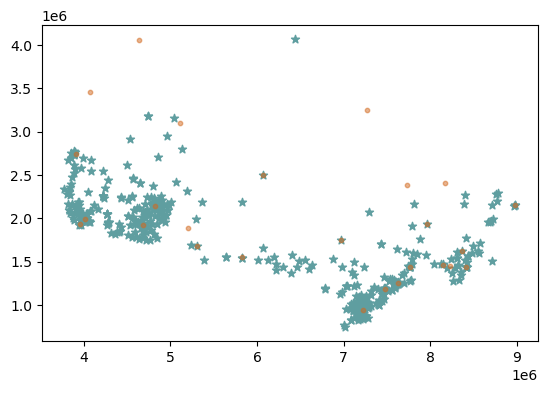

In [119]:
# seleccionamos el subconjunto de los helipuertos
heliports=airports[airports.kind=='heliport'] 
heliports.reset_index(drop=True, inplace=True)

#ploteamos
base=heliports.plot(color='cadetblue',marker="*")
cities.plot(color='chocolate',ax=base,alpha=0.5,markersize=10)

In [120]:
#Vemos la distancia que hay entre cada ciudad y los helipuertos
cities.geometry.apply\
(lambda g: heliports.geometry.distance(g)/1000)

,0,1,2,3,4,5,6,7,8,9,...,461,462,463,464,465,466,467,468,469,470
0,4437.202939,85.819583,589.786935,14.342945,816.068196,1348.568447,264.827339,4247.996426,3763.172662,3592.887880,...,895.399431,895.449100,3226.316330,836.168823,4436.039026,322.604663,3285.824478,1865.276437,1860.899110,4063.031237
1,3762.624081,730.494924,89.790018,672.005618,293.212692,1069.704060,410.520415,3573.314161,3089.095946,2921.475428,...,275.159195,275.265529,2584.984204,342.805833,3761.407771,543.721792,2623.109088,1200.149825,1195.807401,3388.517850
2,3665.282616,889.546461,284.168334,811.672264,47.302250,824.925545,576.133829,3471.723751,3000.263780,2848.749142,...,102.155453,102.116700,2576.393584,96.945975,3656.271649,589.164166,2577.563907,1169.469011,1165.363693,3293.376693
3,2596.444364,1907.464871,1286.973522,1862.001145,1200.756328,1650.281577,1598.992251,2414.698707,1917.008555,1733.933750,...,1064.535485,1064.568835,1410.603038,1223.133848,2606.710779,1726.418260,1425.511991,3.088613,2.973034,2222.134217
4,1300.368030,3413.540443,2808.852844,3375.519672,2717.768508,3029.097781,3113.934158,1181.175567,724.721272,475.824970,...,2584.697425,2584.721670,277.864401,2735.674031,1363.106950,3250.978249,166.275021,1521.880846,1526.147520,982.969285
5,976.525474,3598.258047,2973.437440,3552.308109,2849.274315,3073.202444,3289.174333,838.553748,367.003794,120.890530,...,2722.782091,2722.789874,634.352567,2861.283153,1026.492026,3401.768116,312.988336,1688.500953,1692.885110,636.343658
6,818.272560,3731.378973,3101.997314,3683.283759,2968.370484,3162.139072,3420.129128,679.007547,227.172462,95.173685,...,2844.245291,2844.248110,787.025645,2978.524500,866.803020,3525.434946,472.207777,1822.345320,1826.732235,477.254413
7,657.688957,3836.678767,3198.777441,3783.789642,3045.787410,3182.510918,3521.253052,487.586626,22.894214,267.309664,...,2927.006568,2926.999194,1014.778347,3052.171750,681.525827,3610.405347,677.437213,1937.675917,1942.030847,286.079861
8,4485.251688,4.716895,644.470742,94.602727,885.186947,1429.971251,317.122520,4297.129025,3809.842622,3636.187113,...,958.170456,958.226973,3255.771708,907.533054,4485.864721,404.037991,3323.608242,1906.007295,1901.622003,4110.842282
9,4789.843348,1527.710883,1589.926707,1448.889253,1466.315006,1021.520366,1518.664365,4587.940107,4182.101108,4087.599685,...,1603.324818,1603.234416,3974.473563,1425.920292,4751.494066,1238.677807,3899.162694,2593.797479,2590.311821,4440.621796


In [164]:
# Eliminar duplicados en el DataFrame heliports
heliports = heliports.drop_duplicates(subset='name').reset_index(drop=True)

# Obtener las distancias entre las ciudades y los helipuertos
cities.set_index('CIUDAD').geometry.apply\
(lambda g: heliports.set_index('name').geometry.distance(g)/1000)

name,Halifax / CFB Shearwater Heliport,Victoria Harbour (Camel Point) Heliport,Canmore Municipal Heliport,Harbour (Public) Heliport,Edmonton / St. Albert (Delta Helicopters) Heliport,Hay River (District) Heliport,Kelowna (Alpine) Heliport,Moncton / Salisbury Heliport,C J.H.L.(Joe) Lecomte) Heliport,Mont Tremblant/St-Jovite Heli-Tremblant,...,Viking Health Centre Helipad,Viking Health Centre George H. Roddick Heliport,Wallaceburg/Chatham-Kent Health Alliance Heliport,Westlock Healthcare Centre Heliport,Westville Community Helipad,Frontline Helicopters Heliport,Rostrevor Heliport,Winnipeg (City of Winnipeg) Heliport,Health Sciences Centre Helipad,Woodstock/Snokist Heliport
CIUDAD,,,,,,,,,,,,,,,,,,,,,
Vancouver,4437.202939,85.819583,589.786935,14.342945,816.068196,1348.568447,264.827339,4247.996426,3763.172662,3592.887880,...,895.399431,895.449100,3226.316330,836.168823,4436.039026,322.604663,3285.824478,1865.276437,1860.899110,4063.031237
Calgary,3762.624081,730.494924,89.790018,672.005618,293.212692,1069.704060,410.520415,3573.314161,3089.095946,2921.475428,...,275.159195,275.265529,2584.984204,342.805833,3761.407771,543.721792,2623.109088,1200.149825,1195.807401,3388.517850
Edmonton,3665.282616,889.546461,284.168334,811.672264,47.302250,824.925545,576.133829,3471.723751,3000.263780,2848.749142,...,102.155453,102.116700,2576.393584,96.945975,3656.271649,589.164166,2577.563907,1169.469011,1165.363693,3293.376693
Winnipeg,2596.444364,1907.464871,1286.973522,1862.001145,1200.756328,1650.281577,1598.992251,2414.698707,1917.008555,1733.933750,...,1064.535485,1064.568835,1410.603038,1223.133848,2606.710779,1726.418260,1425.511991,3.088613,2.973034,2222.134217
Toronto,1300.368030,3413.540443,2808.852844,3375.519672,2717.768508,3029.097781,3113.934158,1181.175567,724.721272,475.824970,...,2584.697425,2584.721670,277.864401,2735.674031,1363.106950,3250.978249,166.275021,1521.880846,1526.147520,982.969285
Ottawa,976.525474,3598.258047,2973.437440,3552.308109,2849.274315,3073.202444,3289.174333,838.553748,367.003794,120.890530,...,2722.782091,2722.789874,634.352567,2861.283153,1026.492026,3401.768116,312.988336,1688.500953,1692.885110,636.343658
Montreal,818.272560,3731.378973,3101.997314,3683.283759,2968.370484,3162.139072,3420.129128,679.007547,227.172462,95.173685,...,2844.245291,2844.248110,787.025645,2978.524500,866.803020,3525.434946,472.207777,1822.345320,1826.732235,477.254413
Quebec,657.688957,3836.678767,3198.777441,3783.789642,3045.787410,3182.510918,3521.253052,487.586626,22.894214,267.309664,...,2927.006568,2926.999194,1014.778347,3052.171750,681.525827,3610.405347,677.437213,1937.675917,1942.030847,286.079861
Victoria,4485.251688,4.716895,644.470742,94.602727,885.186947,1429.971251,317.122520,4297.129025,3809.842622,3636.187113,...,958.170456,958.226973,3255.771708,907.533054,4485.864721,404.037991,3323.608242,1906.007295,1901.622003,4110.842282


In [165]:
#try 3
cities.set_index('CIUDAD').geometry.apply\
(lambda g: heliports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

name,Abbotsford (Regional Hospital & Cancer Centre) Heliport,Abbotsford (Sumas Mountain) Heliport,Abbotsford (Teck) Heliport,Aberdeen Hospital Heliport,Active Pass Lighthouse Heliport,Addenbroke Island Lightstation Helipad,Aerosmith Heli Service Heliport,Ajax (Pickering General Hospital) Heliport,Allan Dale Residence Heliport,Allan Dale Trailers & RV Heliport,...,Williams Lake / Pioneer Heliport,Williams Lake / Wayne Peterson Heliport,Wilson's Heliport,Winchester District Memorial Hospital Heliport,Winnipeg (City of Winnipeg) Heliport,Woodstock (Hospital) Heliport,Woodstock/Snokist Heliport,Yarmouth (Regional Hospital) Heliport,Évasion Hélicoptère Heliport,Île d'Orléans Heliport
CIUDAD,,,,,,,,,,,,,,,,,,,,,
Calgary,629.286443,618.376163,630.639136,3764.210773,702.027465,955.235906,760.531025,2739.678344,138.775406,141.512459,...,567.597010,566.022843,2714.931820,2921.277571,1200.149825,2664.110756,3388.517850,3632.648458,3009.078905,3130.796202
Charlottetown,4321.545930,4310.707180,4323.061511,85.495592,4394.451350,4574.190104,4450.058282,1299.426580,3635.542645,3645.479018,...,4188.980648,4186.784742,1350.231011,974.255944,2541.674378,1463.551550,354.214354,362.991981,828.361161,601.381031
Churchill,2082.690446,2071.214624,2080.268481,2540.239529,2147.748534,2212.634212,2176.817433,1941.300824,1390.550258,1396.621590,...,1860.050509,1857.708963,1944.392882,1961.820780,982.231401,1958.006856,2225.320834,2509.542695,1985.360892,1998.862221
Edmonton,784.719751,773.245554,782.618672,3658.800834,850.974456,995.118497,886.917929,2703.970468,119.708392,118.684553,...,605.145022,602.977638,2683.595097,2859.985369,1169.469011,2642.895799,3293.376693,3548.280810,2937.136515,3039.263846
Fredericton,4117.384754,4106.716497,4119.392537,307.103803,4190.720760,4387.770909,4249.520874,1028.866828,3439.378581,3449.656727,...,3999.057618,3996.903830,1079.486843,705.714948,2321.161776,1192.462610,101.183846,221.139371,562.346453,361.338719
Goose Bay,4141.050711,4129.702012,4140.403313,872.814674,4210.581295,4316.091025,4251.416061,1716.526566,3438.547318,3446.778250,...,3952.413149,3950.099508,1765.741767,1408.397490,2500.435409,1876.553724,938.586384,1131.466487,1270.114495,1010.526338
Halifax,4382.576500,4371.898904,4384.558200,130.390526,4455.893079,4650.986488,4514.485527,1256.936520,3703.843046,3714.083228,...,4262.776908,4260.616488,1306.114459,944.818106,2586.233589,1415.997310,366.530724,223.639593,809.147000,626.381831
Inuvik,2183.113003,2177.374230,2172.020677,4540.439067,2186.616758,1835.978673,2124.247571,4057.198724,2022.533664,2014.234219,...,1854.881554,1853.889914,4057.602288,4078.149420,2781.798689,4062.708696,4278.106113,4570.225091,4092.509274,4075.256136
Iqaluit,3460.672430,3449.286099,3456.895504,2041.218777,3521.022946,3514.295394,3537.999214,2289.358684,2787.536826,2792.385339,...,3202.051503,3199.715005,2323.206051,2096.633501,2230.375225,2402.370996,1934.779643,2206.445699,2017.251243,1848.236197


In [166]:
#guardamos la matriz de los puertos y aeropuertos medianos
distanceMatrixKM_sea_air= seaports_canada_3347.set_index('portName').geometry.apply\
                          (lambda g: mediumAirports.set_index('name').geometry.distance(g)/1000).\
                          sort_index(axis=0).sort_index(axis=1)

In [167]:
# Distancia promedio de un puerto a los aeropuerto medianos (sorted)
distanceMatrixKM_sea_air.mean(axis=1).sort_values(ascending=True)

portName
Churchill         1488.305162
Heron Bay         1586.345209
Thunder Bay       1591.871819
Michipicoten      1627.356443
Quebec Harbour    1635.701962
                     ...     
Bay Roberts       2906.577286
Holyrood          2924.930476
Long Pond         2927.608871
St John's         2941.784977
Bay Bulls         2948.764156
Length: 261, dtype: float64

In [168]:
# distancia promedio, mínima y máxima
SomeStats=pd.DataFrame()
SomeStats['mean']=distanceMatrixKM_sea_air.mean(axis=1)
SomeStats['min']=distanceMatrixKM_sea_air.min(axis=1)
SomeStats['max']=distanceMatrixKM_sea_air.max(axis=1)
SomeStats.head()

,mean,min,max
portName,,,
Ahousat,2523.881524,31.003389,4947.682926
Alert Bay,2497.527681,1.226883,4925.767129
Alliford Bay,2645.322585,11.885680,5074.135497
Amherstburg,2043.619403,23.596361,4525.914679
Argentia,2879.355770,187.730069,5229.645839


In [169]:
# aeropuerto mediano más lejano a cada puerto
distanceMatrixKM_sea_air.idxmax(axis="columns")

portName
Ahousat         Gander International Airport / CFB Gander
Alert Bay       Gander International Airport / CFB Gander
Alliford Bay    Gander International Airport / CFB Gander
Amherstburg                                 Alert Airport
Argentia                             Beaver Creek Airport
                                  ...                    
Westview        Gander International Airport / CFB Gander
Whycocomagh                          Beaver Creek Airport
Wiarton                                     Alert Airport
Windsor                                     Alert Airport
Wolfe Island                         Beaver Creek Airport
Length: 261, dtype: object

In [170]:
# PUERTO más lejano a cada aeropuerto mediano
distanceMatrixKM_sea_air.idxmax(axis="rows")

name
Aklavik/Freddie Carmichael Airport            Bay Bulls
Akulivik Airport                        Queen Charlotte
Alert Airport                         Pelee I West Dock
Alert Bay Airport                             Bay Bulls
Alma Airport                            Queen Charlotte
                                            ...        
Yarmouth Airport                        Queen Charlotte
Yellowknife International Airport             Bay Bulls
York Landing Airport                          Bay Bulls
Yorkton Municipal Airport                     Bay Bulls
Îles-de-la-Madeleine Airport            Queen Charlotte
Length: 328, dtype: object

In [171]:
#aeropuerto mediano más cercano a cada puerto
distanceMatrixKM_sea_air.idxmin(axis="columns")

portName
Ahousat                       Tofino / Long Beach Airport
Alert Bay                               Alert Bay Airport
Alliford Bay                             Sandspit Airport
Amherstburg                               Windsor Airport
Argentia        Gander International Airport / CFB Gander
                                  ...                    
Westview                             Powell River Airport
Whycocomagh                       Port Hawkesbury Airport
Wiarton                                   Wiarton Airport
Windsor                                   Windsor Airport
Wolfe Island               Kingston Norman Rogers Airport
Length: 261, dtype: object

In [172]:
# puerto más ceracano a cada aeropuerto mediano
distanceMatrixKM_sea_air.idxmin(axis="rows")

name
Aklavik/Freddie Carmichael Airport                   Tuktoyaktuk
Akulivik Airport                                   Deception Bay
Alert Airport                                       Resolute Bay
Alert Bay Airport                                      Alert Bay
Alma Airport                          Chicoutimi (Port Saguenay)
                                                 ...            
Yarmouth Airport                                           Digby
Yellowknife International Airport                     Coppermine
York Landing Airport                                   Churchill
Yorkton Municipal Airport                              Churchill
Îles-de-la-Madeleine Airport                          Georgetown
Length: 328, dtype: object

In [ ]:
#Ejercicio 2

In [183]:
rivers['NOMBRE'].values.tolist()

['Ajaqutalik',
 'Albany',
 'Amadjuak',
 'Assinibaine',
 'Athabasca',
 'Atikonak',
 'Attawapiskat',
 'Back',
 'Burnside',
 'Caniapiscau',
 'Canoe',
 'Churchill',
 'Churchill',
 'Columbia',
 'Coppermine',
 'Dauphin',
 'Dubawnt',
 'Feuilles',
 'Finlay',
 'Flathead',
 'Fraser',
 'Gander',
 'George',
 'Grand Baleine',
 'Great Bear',
 'Harricana',
 'Hayes',
 'Hayes',
 'Hone',
 'Kechika',
 'Kenogami',
 'Kepimits',
 'Koukdjuak',
 'Kunjjua',
 'Liard',
 'Mackenzie',
 'Macmillian',
 'Manicouragan',
 'Mattagami',
 'Melezes',
 'Missinaibi',
 'Mistassibi',
 'Nechako',
 'Nelson',
 'Niagara',
 'Nipigon',
 'North Saskatchewan',
 'Nottaway',
 'Ottawa',
 'Parsnip',
 'Peace',
 'Peel',
 'Pend Oreille',
 'Peribonca',
 'Porcupine',
 'Rainy',
 'Red Deer',
 'Red River of the North',
 'Richelieu',
 'Rupert',
 'Saguenay',
 'Saskatchewan',
 'Severn',
 'Slave',
 'Souris',
 'South Saskatchewan',
 'St. Clair',
 'St. Johns',
 'St. Lawrence',
 'Stikine',
 'Sungukpagaluk',
 'Thelon',
 'Thlewiaza',
 'Waterhen',
 'Yukon'

In [209]:
#seleccionamos un río
rivers[rivers.NOMBRE.str.contains('Peace')]

,NOMBRE,CUENCA,geometry
50,Peace,Mackenzie,"MULTILINESTRING ((4316242.983 2780170.573, 431..."


In [210]:
rivers[rivers.NOMBRE.str.contains('Peace')].iloc[0].geometry.distance(heliports.geometry)

0      3.533625e+06
1      7.443899e+05
2      5.574208e+05
3      6.474922e+05
4      3.575338e+05
           ...     
463    3.615547e+05
464    2.606159e+06
465    1.346038e+06
466    1.343094e+06
467    3.175439e+06
Name: geometry, Length: 468, dtype: float64

In [212]:
distanceMatrixKM_riv_hel=rivers.set_index('NOMBRE').geometry.apply\
(lambda g: heliports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)
distanceMatrixKM_riv_hel

name,Abbotsford (Regional Hospital & Cancer Centre) Heliport,Abbotsford (Sumas Mountain) Heliport,Abbotsford (Teck) Heliport,Aberdeen Hospital Heliport,Active Pass Lighthouse Heliport,Addenbroke Island Lightstation Helipad,Aerosmith Heli Service Heliport,Ajax (Pickering General Hospital) Heliport,Allan Dale Residence Heliport,Allan Dale Trailers & RV Heliport,...,Williams Lake / Pioneer Heliport,Williams Lake / Wayne Peterson Heliport,Wilson's Heliport,Winchester District Memorial Hospital Heliport,Winnipeg (City of Winnipeg) Heliport,Woodstock (Hospital) Heliport,Woodstock/Snokist Heliport,Yarmouth (Regional Hospital) Heliport,Évasion Hélicoptère Heliport,Île d'Orléans Heliport
NOMBRE,,,,,,,,,,,,,,,,,,,,,
Ajaqutalik,2849.574087,2838.641913,2843.842992,2710.319012,2901.304795,2821.958191,2901.799518,2639.960221,2235.377942,2237.325475,...,2554.597634,2552.347170,2660.723785,2535.746982,2039.895800,2711.690761,2532.109841,2820.538585,2497.442972,2389.275347
Albany,2121.994476,2111.217861,2123.706809,1584.643371,2195.085923,2398.800287,2252.690763,912.938334,1443.386532,1453.840470,...,2007.064210,2004.959892,917.918639,927.258906,403.137764,940.969469,1228.659910,1499.350831,948.477195,984.149050
Amadjuak,3321.915141,3310.587989,3317.742187,2134.991136,3380.717273,3359.667343,3394.475547,2328.047813,2657.791262,2662.105189,...,3055.478540,3053.152322,2359.473069,2152.408059,2163.245046,2433.509879,2017.834469,2292.666972,2081.322514,1922.452429
Assinibaine,1644.262407,1634.285771,1647.860340,2609.102241,1718.092936,1985.858234,1787.089334,1541.296134,1025.539137,1037.297236,...,1592.512869,1590.684540,1518.240116,1724.713886,2.753663,1473.688004,2221.100271,2450.590066,1818.846509,1960.776140
Athabasca,480.575387,469.168313,477.093748,3475.448838,542.986798,674.256165,573.763349,2664.373033,230.710692,222.176256,...,283.733899,281.552064,2651.056164,2778.306673,1185.353666,2626.538270,3141.397286,3416.837749,2837.723977,2901.723991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sungukpagaluk,2462.116484,2454.286509,2452.139241,4097.374612,2481.929698,2201.828933,2436.895063,3755.960033,2133.597154,2128.031569,...,2121.937127,2120.416336,3763.116130,3734.823219,2644.934342,3783.395710,3866.060578,4159.382377,3730.853438,3682.406474
Thelon,1743.638640,1732.978341,1737.222667,2765.116896,1791.953872,1708.760473,1788.056795,2399.086340,1180.897116,1180.412764,...,1439.926853,1437.701910,2410.110412,2362.203212,1439.069689,2440.248805,2507.188130,2800.128940,2356.552445,2313.710035
Thlewiaza,1733.036726,1721.768286,1728.565983,2641.067189,1790.822230,1788.567736,1804.223909,2113.859687,1090.507928,1093.038001,...,1467.112632,1464.775707,2119.270214,2116.958179,1083.708625,2137.605157,2343.446141,2631.735220,2131.348107,2126.643131


In [214]:
distanceMatrixKM_riv_hel.loc['Peace'].sort_values()

name
Fort St. John (Hospital) Heliport               4.893252
Country Gardens B&B Heliport                    7.143294
Queen Elizabeth II Hospital Helipad            81.486252
Grande Prairie (Forestry) Heliport             84.430695
Fort Smith (District) Heliport                 97.158194
                                                ...     
Offer Wadham Lighthouse Helipad              3697.528924
Sable Island Heliport                        3787.655508
Long Pond Heliport                           3894.821459
St. John's (Universal) Heliport              3901.805023
St John's Health Sciences Centre Heliport    3903.522478
Name: Peace, Length: 468, dtype: float64

In [216]:
base=rivers[rivers.NOMBRE.str.contains('Peace')].explore()
heliports.explore(m=base,color='green',marker_kwds=dict(radius=10))

In [218]:
rivers.columns

Index(['NOMBRE', 'CUENCA', 'geometry'], dtype='object')

In [221]:
#Elimina los valores nulos
rivers[~rivers.CUENCA.isna()]

,NOMBRE,CUENCA,geometry
3,Assinibaine,Nelson/Saskatchewan,"LINESTRING (5647695.689 1535314.231, 5653589.2..."
4,Athabasca,Mackenzie,"LINESTRING (4506990.720 2127228.127, 4512692.3..."
10,Canoe,Columbia,"LINESTRING (4408161.378 2244043.229, 4407445.9..."
11,Churchill,Churchill,"MULTILINESTRING ((5841167.230 2364958.406, 584..."
13,Columbia,Columbia,"LINESTRING (4538186.876 1888850.101, 4539161.6..."
15,Dauphin,Nelson/Saskatchewan,"MULTILINESTRING ((5780372.975 1776876.296, 577..."
18,Finlay,Mackenzie,"LINESTRING (4182403.062 2856380.024, 4182955.2..."
19,Flathead,Columbia,"LINESTRING (4574707.400 1775959.210, 4580037.9..."
24,Great Bear,Mackenzie,"MULTILINESTRING ((4820694.516 3539848.271, 480..."
29,Kechika,Mackenzie,"LINESTRING (4312642.732 2918508.864, 4314261.9..."


In [222]:
systems=rivers.dissolve(by='CUENCA')
systems

,geometry,NOMBRE
CUENCA,,
Churchill,"MULTILINESTRING ((5841167.230 2364958.406, 584...",Churchill
Columbia,"MULTILINESTRING ((4408161.378 2244043.229, 440...",Canoe
Mackenzie,"MULTILINESTRING ((4506990.720 2127228.127, 451...",Athabasca
Nelson/Saskatchewan,"MULTILINESTRING ((5647695.689 1535314.231, 565...",Assinibaine
St. Lawrence,"MULTILINESTRING ((7279027.524 853236.309, 7279...",Niagara
Yukon,"MULTILINESTRING ((4463169.308 3595546.764, 446...",Macmillian


In [223]:
# format the GDF:
systems['NAME']=systems.index
systems.reset_index(drop=True,inplace=True)
systems


,geometry,NOMBRE,NAME
0,"MULTILINESTRING ((5841167.230 2364958.406, 584...",Churchill,Churchill
1,"MULTILINESTRING ((4408161.378 2244043.229, 440...",Canoe,Columbia
2,"MULTILINESTRING ((4506990.720 2127228.127, 451...",Athabasca,Mackenzie
3,"MULTILINESTRING ((5647695.689 1535314.231, 565...",Assinibaine,Nelson/Saskatchewan
4,"MULTILINESTRING ((7279027.524 853236.309, 7279...",Niagara,St. Lawrence
5,"MULTILINESTRING ((4463169.308 3595546.764, 446...",Macmillian,Yukon


In [ ]:
distanceMatrixKM_sys_air=systems.set_index('NAME').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sys_air

In [ ]:
mins=distanceMatrixKM_sys_air.idxmin(axis="columns")
mins

In [ ]:
# one of them
mins[1]

In [ ]:
base=systems.explore()
# the closest
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
# the NOT closest
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

In [ ]:
#Ejercicio 3

In [ ]:
systems.convex_hull.plot()

In [ ]:
systems_hulls=systems.convex_hull.to_frame()
systems_hulls['system']=['Amazon', 'Parana']
systems_hulls.rename(columns={0:'geometry'},inplace=True)
systems_hulls=systems_hulls.set_geometry('geometry')
systems_hulls.crs="EPSG:5641"
systems_hulls

In [ ]:
distanceMatrixKM_sysHull_air=systems_hulls.set_index('system').geometry.apply\
(lambda g: largeAirports.set_index('name').geometry.distance(g)/1000).\
sort_index(axis=0).sort_index(axis=1)

distanceMatrixKM_sysHull_air

In [ ]:
mins=distanceMatrixKM_sysHull_air.idxmin(axis="columns")
mins

In [ ]:
# plotting
base=systems_hulls.explore()
largeAirports[largeAirports.name.isin(mins)].explore(m=base,color='red',marker_kwds=dict(radius=10))
largeAirports[~largeAirports.name.isin(mins)].explore(m=base,color='blue',marker_kwds=dict(radius=5))

In [ ]:
#Ejercicio 4

In [ ]:
# remember:
distanceMatrixKM_riv_air

In [ ]:
# getting a value (it can be any value)
distanceMatrixKM_riv_air.loc['Amazon'].min()

In [ ]:
minMts=distanceMatrixKM_riv_air.loc['Amazon'].min()*1000

#the buffer is a polygon:
rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)

In [ ]:
# see buffer:
bufferAroundAmazon=rivers[rivers.NAME=='Amazon'].buffer(distance = minMts)
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})

In [ ]:
small_airports=airports[airports.kind=='small_airport']

# plotting
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
small_airports.explore(m=bufferAsBase,color='black')

In [ ]:
riversWithinBuffer=small_airports.clip(mask=bufferAroundAmazon)
#
riversWithinBuffer

In [ ]:
bufferAsBase=bufferAroundAmazon.explore(color='red')
rivers[rivers.NAME=='Amazon'].explore(m=bufferAsBase,color='blue',style_kwds={'weight':0.5})
riversWithinBuffer.explore(m=bufferAsBase,color='black')

In [ ]:
# minimum of all the minimum by row
distanceMatrixKM_riv_air.min(axis=1).min() 

In [ ]:
# using the previous value
minMinMts_5=5*distanceMatrixKM_riv_air.min(axis=1).min()*1000


allMinBuffer=rivers.buffer(distance = minMinMts_5).explore(color='red')
rivers.explore(m=allMinBuffer,color='blue',style_kwds={'weight':0.5})
small_airports.explore(m=allMinBuffer,color='black')

In [ ]:
# you see all the buffer polygons:
rivers.buffer(distance = minMinMts_5)

In [ ]:
# notice
riversAll_buf=rivers.buffer(distance = minMinMts_5)
type(riversAll_buf)

In [ ]:
# formatting
riversAll_bufDF=rivers_buf.to_frame()
riversAll_bufDF.rename(columns={0:'geometry'},inplace=True)
riversAll_bufDF = riversAll_bufDF.set_geometry("geometry")
riversAll_bufDF.crs

In [ ]:
allRiversWithinBuffs=small_airports.clip(riversAll_bufDF)
allRiversWithinBuffs

In [ ]:
# simple
base=riversAll_bufDF.plot(color='yellow')
allRiversWithinBuffs.plot(ax=base, color='green', markersize=1)

In [ ]:
# folium

base=riversAll_bufDF.explore(color='yellow')
allRiversWithinBuffs.explore(m=base, color='green')